In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load the summaries + embeddings + cluster IDs
df = pd.read_csv("clustered_summaries_k30.csv")
df['Embedding'] = df['Embedding'].apply(lambda x: np.array(list(map(float, x.split(',')))))

# Force pandas to treat the entire row as a single string, then split it manually
centroids_df = pd.read_csv("cluster_centroids_k30.csv")  # Assumes first row is header
centroids = centroids_df['Centroid_Vector'].apply(lambda x: np.array(list(map(float, x.split(','))))).to_list()

In [3]:
# # Stack embeddings into matrix
# embeddings = np.vstack(df['Embedding'].values)

# # Compute cosine similarity matrix
# similarity_matrix = cosine_similarity(embeddings)

# # Threshold for similarity
# threshold = 0.97
# similar_pairs = []

# n = len(similarity_matrix)
# for i in range(n):
#     for j in range(i + 1, n):
#         if similarity_matrix[i, j] >= threshold:
#             similar_pairs.append((i, j, similarity_matrix[i, j]))

# # Sort pairs by similarity score (descending)
# similar_pairs.sort(key=lambda x: x[2], reverse=True)

# # Print structured results
# print(f"\nFound {len(similar_pairs)} summary pairs with cosine similarity ≥ {threshold}:\n")

# for idx, (i, j, sim) in enumerate(similar_pairs, 1):
#     print(f"👉Pair {idx}: (Index {i}, Index {j}) — Similarity: {sim:.4f}")
#     print(f"📌Summary {i}: {df.loc[i, 'Summary']}")
#     print(f"📌Summary {j}: {df.loc[j, 'Summary']}")
#     print("-" * 100)


# the outpust of this attached as a text file

In [4]:
print("Closest Summary to Each Cluster Centroid:\n")

for cluster_id, centroid_vec in enumerate(centroids):
    # Get embeddings of summaries in this cluster
    cluster_data = df[df['Cluster_Label'] == cluster_id]
    embeddings = np.stack(cluster_data['Embedding'].values)

    # Compute cosine similarity to the centroid
    similarities = cosine_similarity([centroid_vec], embeddings)[0]
    closest_idx = similarities.argmax()
    closest_summary = cluster_data.iloc[closest_idx]['Summary']

    # Trim to first 50 words
    trimmed_summary = ' '.join(closest_summary.split()[:50]) + "..."

    print(f"Cluster {cluster_id}:")
    print(f"→ Closest Summary: {trimmed_summary}\n")
    print("-" * 80)
    # comment this to look at all of them
    if cluster_id == 6:
        break


Closest Summary to Each Cluster Centroid:

Cluster 0:
→ Closest Summary: a sample is just a smaller group taken from a larger population. any calculations we make from a sample, like averages, variances, or standard deviations, are called statistics, while the same calculations done on the entire population are known as parameters. the goal is often to estimate these population parameters...

--------------------------------------------------------------------------------
Cluster 1:
→ Closest Summary: we began with an analysis of pivot tables in excel, which can be helpful for summarizing large datasets by arranging and aggregating information. we learned how to create pivot tables, re-arrange fields, and calculate important metrics like sums, averages, counts, and percentages to gain meaningful insights. after that we learned...

--------------------------------------------------------------------------------
Cluster 2:
→ Closest Summary: we started off by discussing that with nominal

C:\Users\pradh\AppData\Local\Temp\ipykernel_19996\2329777327.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


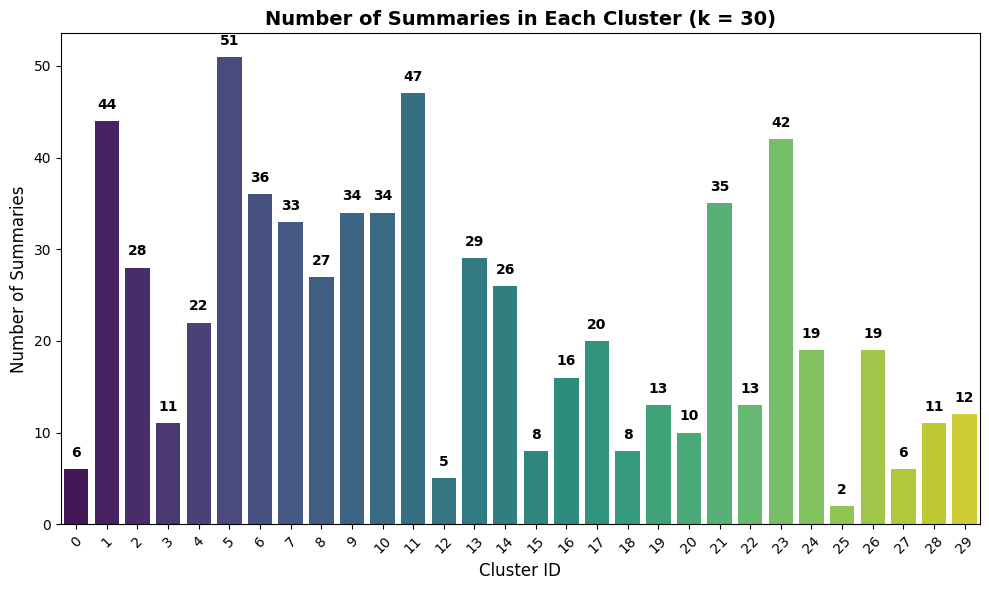

In [5]:
# Count summaries per cluster
cluster_counts = df['Cluster_Label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")

# Annotate count on each bar
for i, count in enumerate(cluster_counts.values):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title(f"Number of Summaries in Each Cluster (k = {len(centroids)})", fontsize=14, weight='bold')
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("Number of Summaries", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


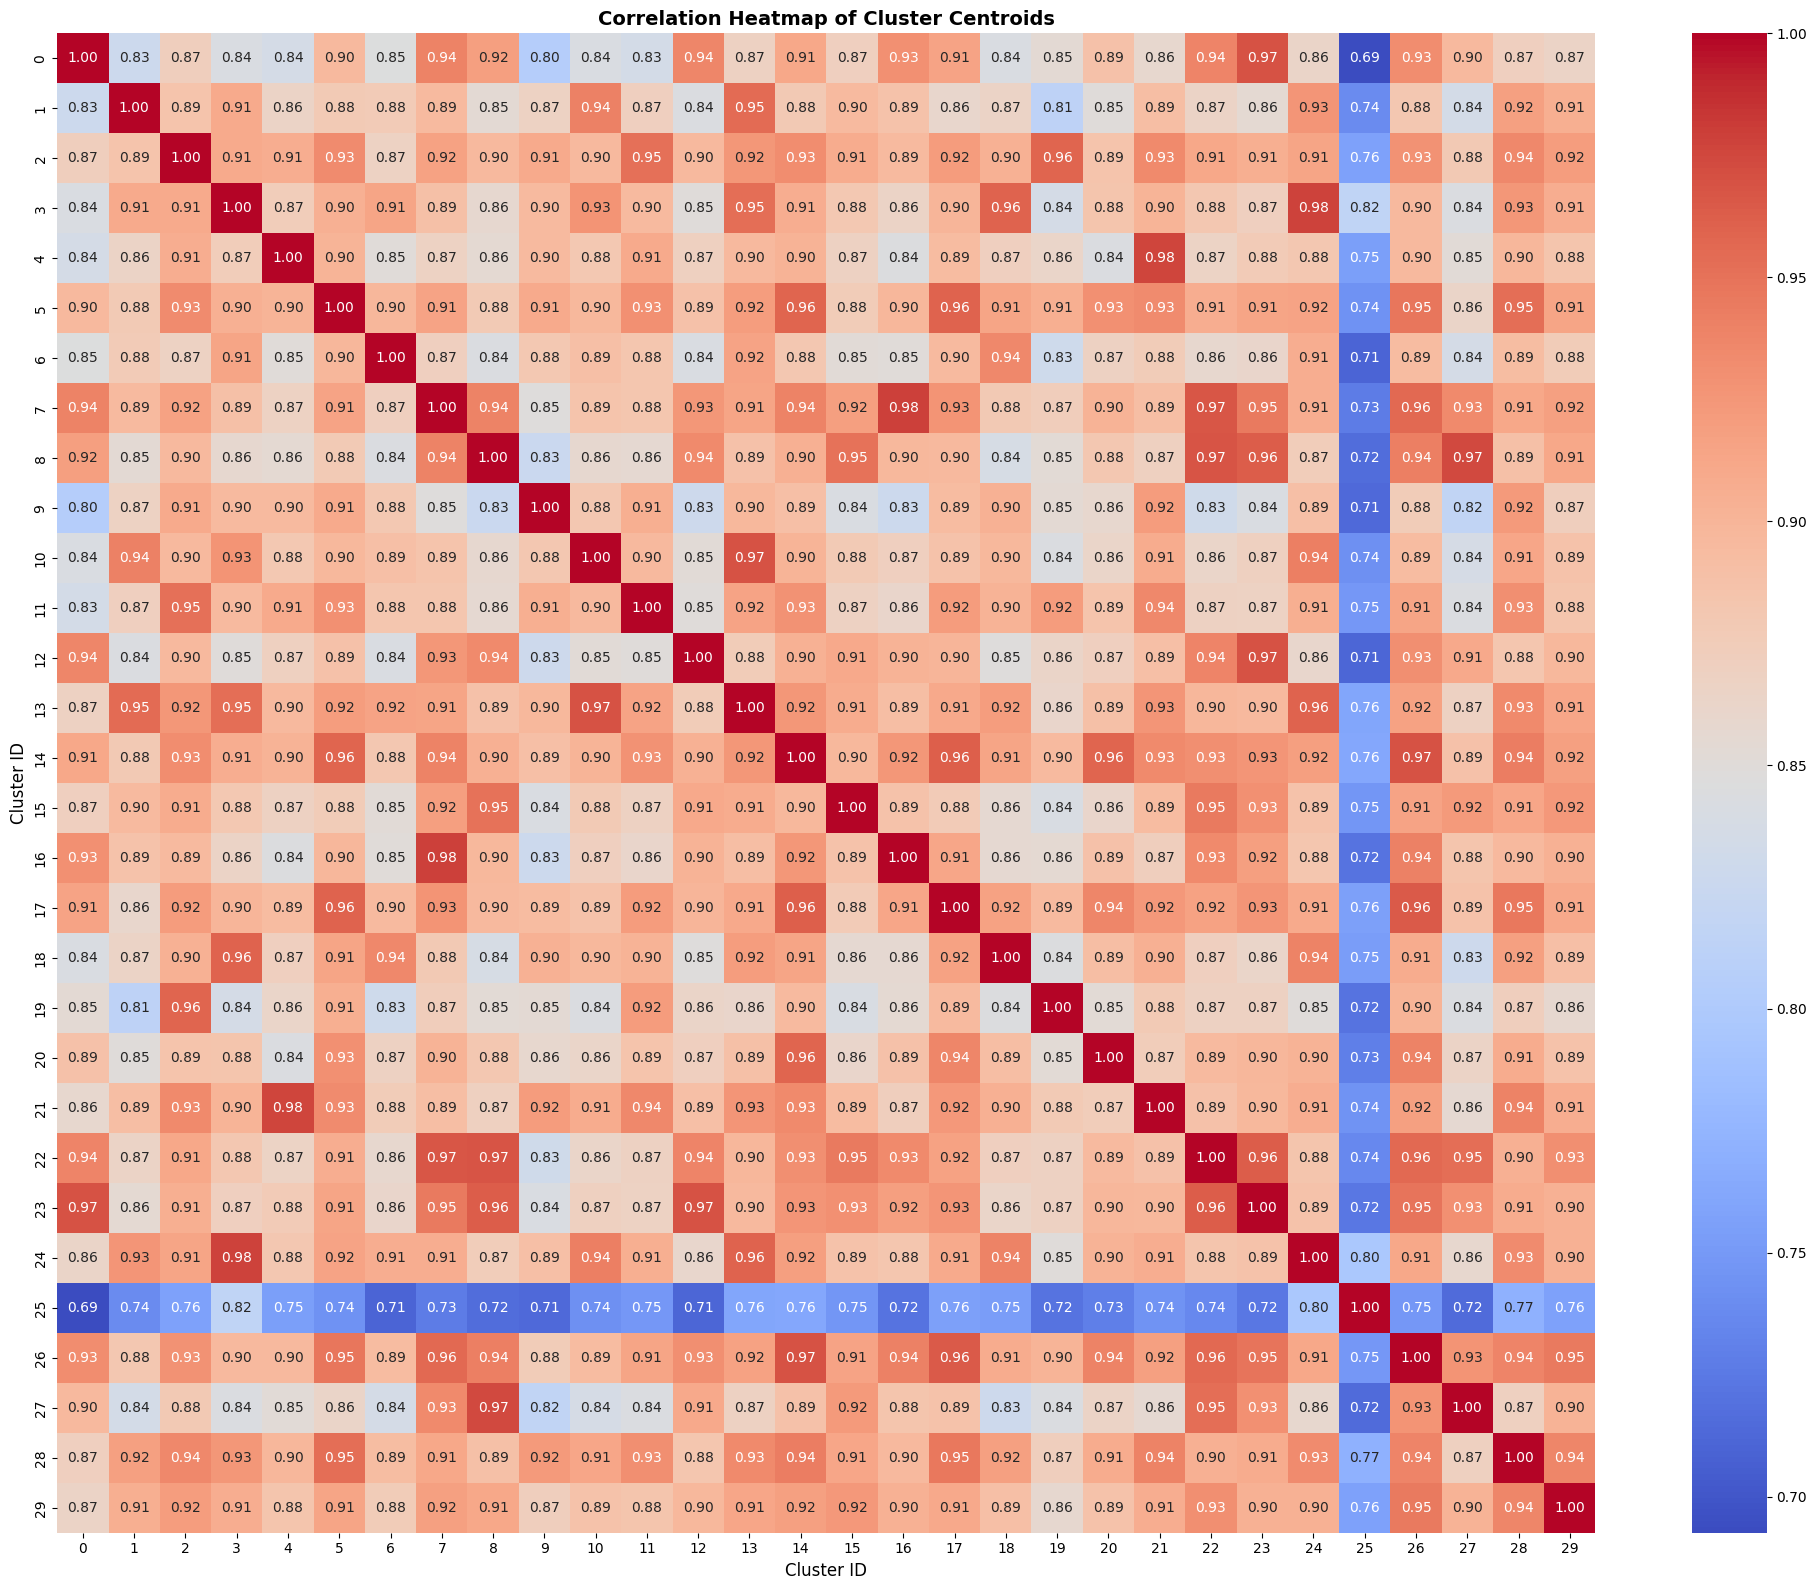

In [6]:
# Compute correlation matrix of centroids
centroid_matrix = np.vstack(centroids)
centroid_corr = np.corrcoef(centroid_matrix)

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(centroid_corr, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(len(centroids)), yticklabels=range(len(centroids)))

plt.title("Correlation Heatmap of Cluster Centroids", fontsize=14, weight='bold')
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("Cluster ID", fontsize=12)
plt.tight_layout()
plt.show()

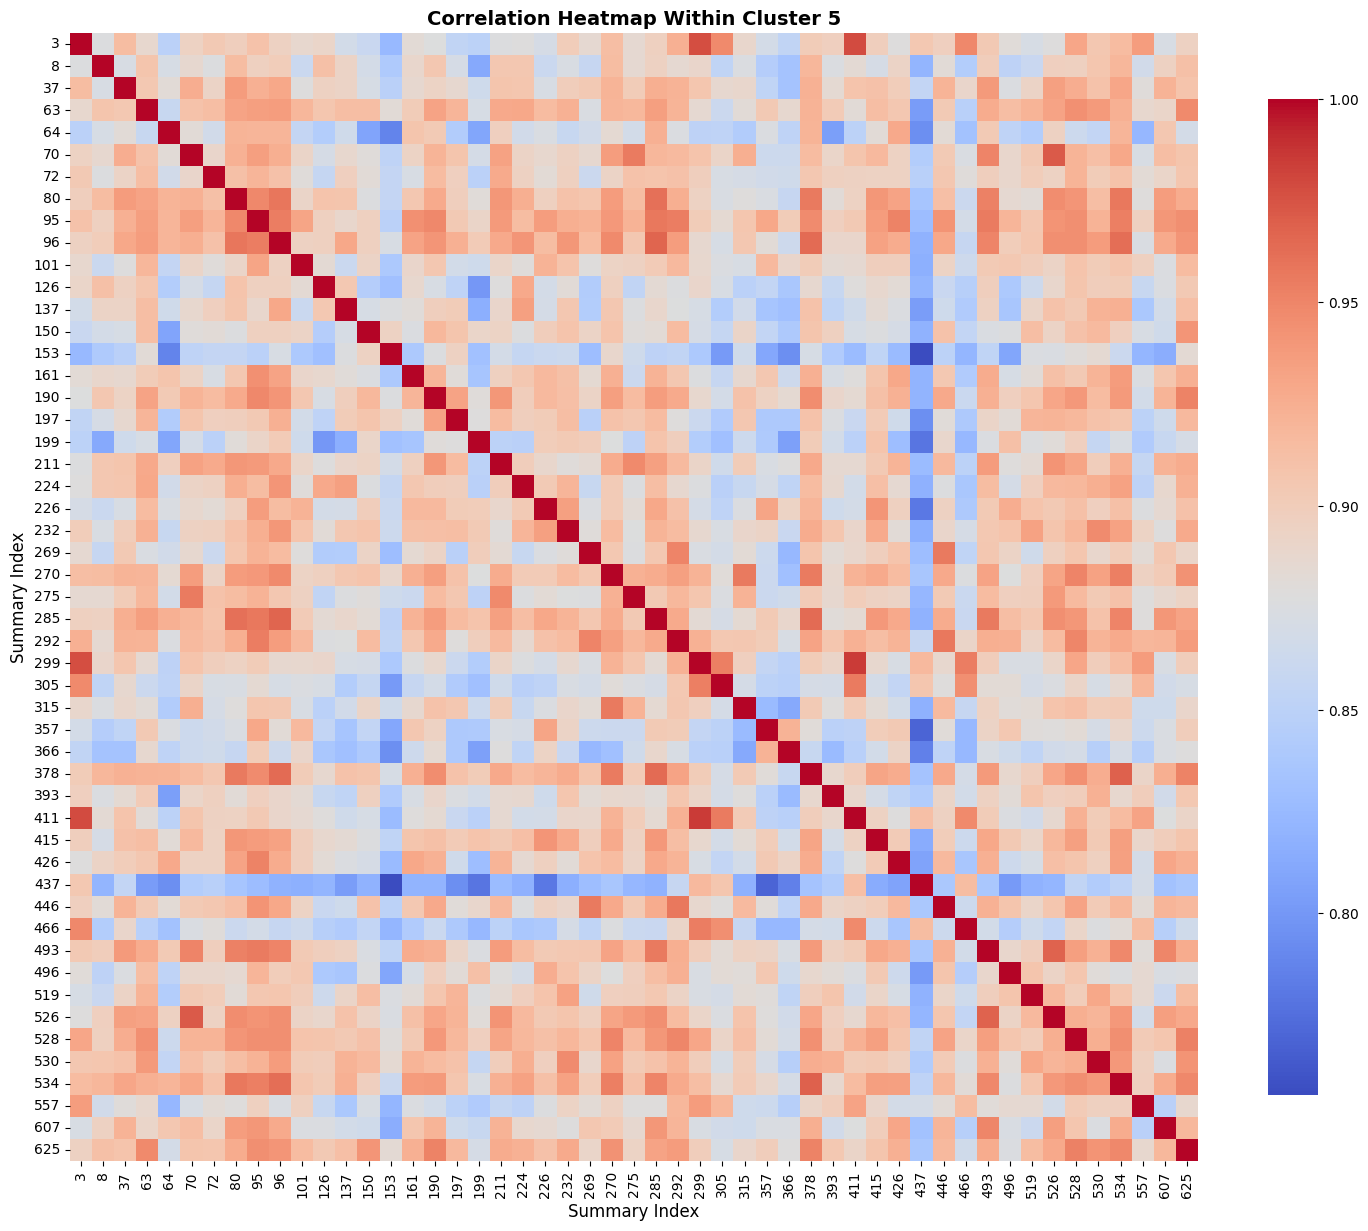

In [7]:
def plot_cluster_correlation(cluster_id):
    # 1. Filter the DataFrame for this cluster
    cluster_data = df[df['Cluster_Label'] == cluster_id]
    if len(cluster_data) < 2:
        print(f"Cluster {cluster_id} has fewer than 2 summaries. Skipping.")
        return

    # 2. Stack the already‑loaded numpy embeddings
    embeddings = np.vstack(cluster_data['Embedding'].values)  # shape: (n_items, dim)
    indices = cluster_data.index.tolist()                    # matching list of row indices

    # 3. Compute the correlation matrix
    corr_matrix = np.corrcoef(embeddings)

    # 4. Plot
    plt.figure(figsize=(15, 13))
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',
        xticklabels=indices,
        yticklabels=indices,
        square=True,
        cbar_kws={'shrink': .8}
    )
    plt.title(f"Correlation Heatmap Within Cluster {cluster_id}", fontsize=14, weight='bold')
    plt.xlabel("Summary Index", fontsize=12)
    plt.ylabel("Summary Index", fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_cluster_correlation(5)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def print_top_representative_summaries(cluster_id, n=30):
    cluster_data = df[df['Cluster_Label'] == cluster_id].copy()
    if len(cluster_data) < 2:
        print(f"Cluster {cluster_id} has fewer than 2 summaries.")
        return

    # Assume embeddings are already numpy arrays
    embeddings = np.vstack(cluster_data['Embedding'].tolist())

    # Compute centroid
    centroid = np.mean(embeddings, axis=0).reshape(1, -1)

    # Compute cosine similarity
    similarities = cosine_similarity(embeddings, centroid).flatten()
    cluster_data['Similarity'] = similarities

    # Top N similar
    top_summaries = cluster_data.sort_values(by='Similarity', ascending=False).head(n)

    print(f"\n--- Top {n} Representative Summaries from Cluster {cluster_id} ---\n")
    for i, summary in enumerate(top_summaries['Summary'], 1):
        trimmed_summary = ' '.join(summary.split()[:50]) + "..."
        print(f"👉 Summary-{i}: {trimmed_summary}\n")

# Example usage
print_top_representative_summaries(20)


--- Top 30 Representative Summaries from Cluster 20 ---

👉 Summary-1: we recapped in the starting about the closed form solution in multiple linear regression which is impractical as we have to deal with matrix inversion and also one more issue is presence of multi collinearity. also during feature selection if p value is greater than 0.05 we remove that feature...

👉 Summary-2: we learnt about the closed form solution in multiple linear regression but found that it is not feasible as we have to deal with matrix inversion and multi collinearity. also during selection of features if p value is greater than 0.05 we can ignore that feature as it is not...

👉 Summary-3: 1. we learned closed form solution in multiple linear regression . 2. in feature selection we remove the feature if it's p value is greater than 0.05 3. we use 80-20 random split b/w test and train data . 4. overfit can happen if r2 values of test and train...

👉 Summary-4: we started by going over the closed-form solution

In [9]:
# Define the cluster merging map
cluster_merge_map = {
    24: 100, 3: 100, 18: 100, 25: 100,
    22: 101, 27: 101, 8: 101, 15:101,
    23: 102, 12: 102, 0: 102,
    16: 103, 7: 103, 29:103,
    21: 104, 4: 104,
    13: 105, 10: 105,
    2:106, 19:106,
    17:107, 26:107,
    20:108, 14:108
}

# Assign new cluster labels
df['New_Cluster_Label'] = df['Cluster_Label'].apply(
    lambda x: cluster_merge_map.get(x, x)  # Use new ID if in map, else keep old
)

# Create new DataFrame with required columns
new_df = df[['Summary', 'Embedding', 'New_Cluster_Label']]
new_df['New_Cluster_Label'].unique()

# Export to CSV
new_df.to_csv("merged_clustered_summaries.csv", index=False)